# Neural Network for blood cells

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Der Datensatz besteht aus mikroskopischen Bildern von Blutzellen, diese sind in acht Kategorien aufgeteilt:**
1. basophil
2. eosinophil
3. erythroblast
4. ig
5. lymphocyte
6. monocyte
7. neutrophil
8. platelet

## Daten importieren und vorbereiten
Die Daten werden aus dem Verzeichnis geladen und verarbeitet. Die grösse wird auf 224 x 224 Pixel gesetzt und die Bilder werden durchgemischt und in Batches mit je 32 Bildern geladen. 20% der Daten werden zur validation behalten. Die verbleibenden 80% werden erneut aufgeteilt, wobei 80% als Trainingsdaten und 20% als Validierungsdaten dienen. Dies führt zu einem Trainingssatz mit 64%, einem Validierungssatz mit 16% und einem Testdatensatz mit 20% der Bilder.  

In [3]:
import os
import keras

# Import and prepare the first split of datasets
path = os.path.join("/content/drive/MyDrive/Colab Notebooks/bloodcells_dataset/")

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Use image_dataset_from_directory to load your data
dataset, test_dataset = keras.utils.image_dataset_from_directory(
    directory=path,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode="int",
    validation_split=0.2,
    subset="both",
    shuffle=True,
    seed=42
)

# Get class names
class_names = dataset.class_names
print(class_names)

Found 17093 files belonging to 8 classes.
Using 13675 files for training.
Using 3418 files for validation.
['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


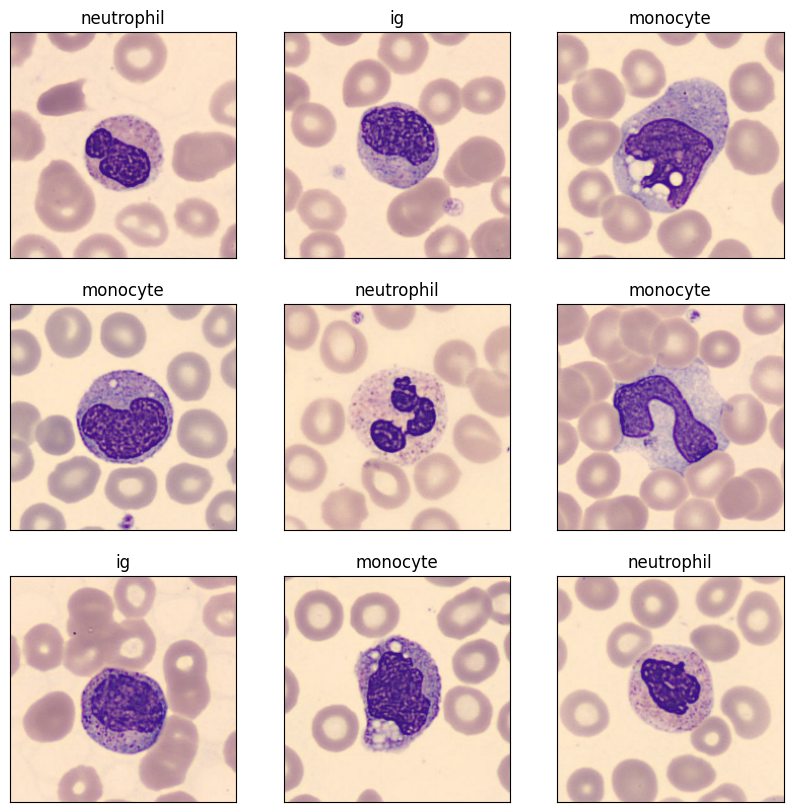

In [4]:
from matplotlib import pyplot as plt

# Plot 16 images from the dataset as examples
fig, ax = plt.subplots(3, 3, figsize=(10,10))
ax = ax.flat
for images, labels in dataset.take(1):
  for i in range(9):
    ax[i].set_title(class_names[labels[i].numpy()])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(images[i].numpy().astype("uint8"))

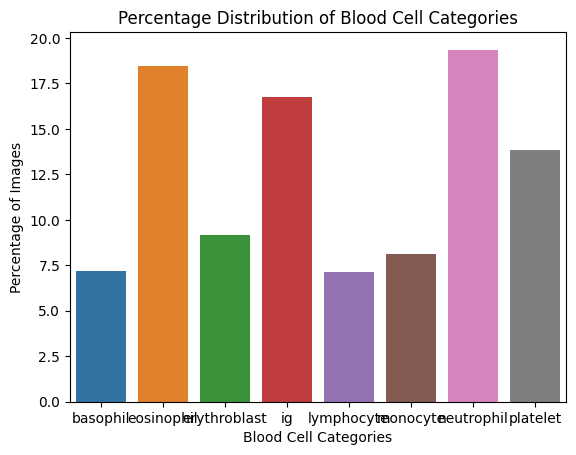

In [5]:
import numpy as np
import seaborn as sns

# Convert labels to NumPy array
labels_array = np.concatenate([labels.numpy() for images, labels in dataset], axis=0)

# Get the class distribution from the dataset
class_distribution = [np.sum(labels_array == i) for i in range(len(class_names))]

# Calculate the percentage distribution
total_samples = sum(class_distribution)
class_percentages = [(count / total_samples) * 100 for count in class_distribution]

# Create a countplot using seaborn with percentages
sns.barplot(x=class_names, y=class_percentages)
plt.xlabel('Blood Cell Categories')
plt.ylabel('Percentage of Images')
plt.title('Percentage Distribution of Blood Cell Categories')
plt.show()

In [6]:
import tensorflow as tf

# Get the total number of elements in the dataset
num_elements = len(dataset)

# Calculate the size of the training set (80% of the total dataset)
train_size = int(0.8 * num_elements)

# Skip the first 'train_size' elements to create the validation dataset
# and prefetch the data for improved performance
val_dataset = dataset.skip(train_size).prefetch(tf.data.AUTOTUNE)

# Take the first 'train_size' elements to create the training dataset
# and prefetch the data for improved performance
train_dataset = dataset.take(train_size).prefetch(tf.data.AUTOTUNE)

# Check the lengths of the resulting datasets
len(train_dataset), len(val_dataset), len(test_dataset) # Output is in batches, BATCH_SIZE=32

(342, 86, 107)

In [7]:
# Check format of the batches, should be -> (32, 224, 224, 3)
for image_batch, labels_batch in train_dataset.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in test_dataset.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 224, 224, 3)
Train labels: (32,)
Validation data: (32, 224, 224, 3)
Validation labels: (32,)
Test data: (32, 224, 224, 3)
Test labels: (32,)


In [8]:
# Check pixel intesities
for image, label in train_dataset.take(1):
  print(tf.reduce_max(image))
  print(tf.reduce_min(image))

tf.Tensor(255.0, shape=(), dtype=float32)
tf.Tensor(2.8126373, shape=(), dtype=float32)


**Fazit:**
* Die 8 Klassen sind unausgeglichen, wobei die häufigste Klasse die Neutrophilen mit 19,4% aller Bilder und die seltenste Klasse die Lymphozyten mit 7,1% ist. Daher würde die Genauigkeit eines zufälligen Modells 19,4% betragen.
* Die Pixelintensitäten reichen von 3,5 bis 255. Daher ist eine Neuskalierung der Pixelintensitäten angemessen.

## Model 1 - Simple CNN

In [27]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping

# Implement a call back function. Stopps after quantity stopps improving
callBack = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Set the seed for TensorFlow operations
tf.random.set_seed(24)

# Defining a simple CNN model
model1 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax')
])

model1.summary()

# Compiling the model
model1.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Training the model
history1 = model1.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[callBack])

result1 = model1.evaluate(test_dataset)

print("Test Loss:", result1[0])
print("Test Accuracy:", result1[1])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_111 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_112 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 186624)           

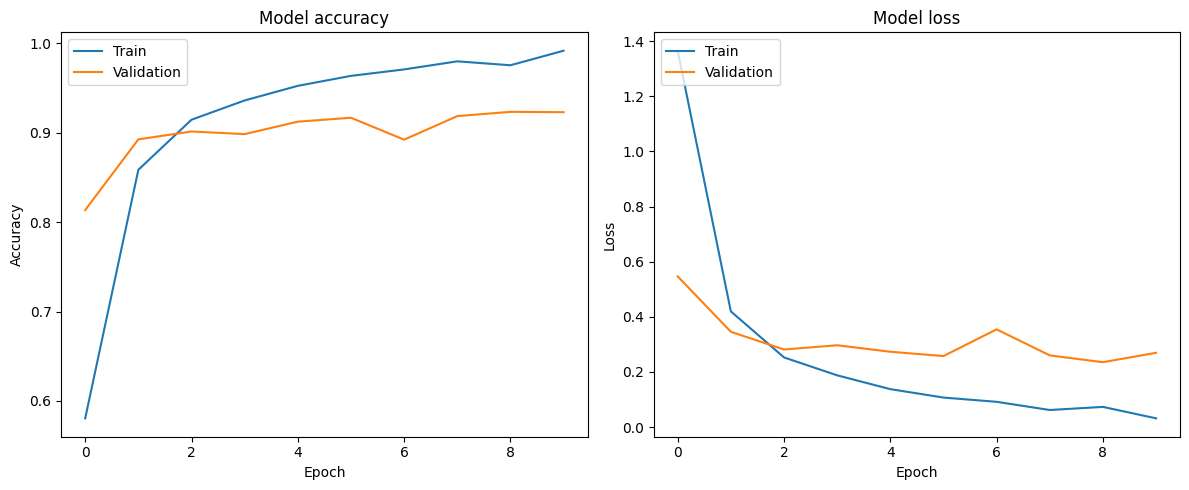

In [28]:
# Plot training & validation accuracy valuess
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

107/107 [==============================] - 9s 83ms/step


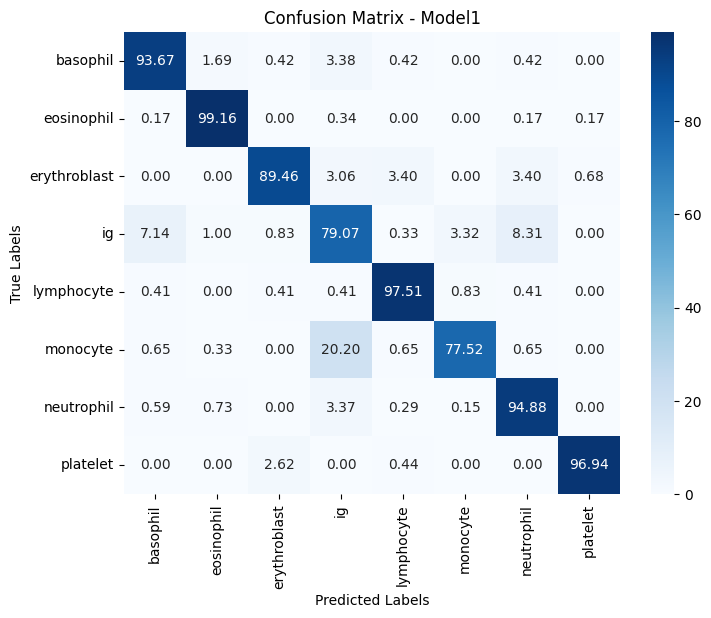

In [29]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Assuming model2 is your trained model
predictions_model1 = model1.predict(test_dataset)
predicted_labels_model1 = np.argmax(predictions_model1, axis=1)

# Assuming test_labels_model2 contains the true labels of your test dataset
true_labels_model1 = np.concatenate([labels.numpy() for _, labels in test_dataset])

# Generate confusion matrix
conf_matrix_model1 = confusion_matrix(true_labels_model1, predicted_labels_model1)

# Calculate percentages
conf_matrix_percentages_model1 = conf_matrix_model1 / conf_matrix_model1.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentages_model1, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Model1')
plt.show()

86/86 [==============================] - 31s 85ms/step


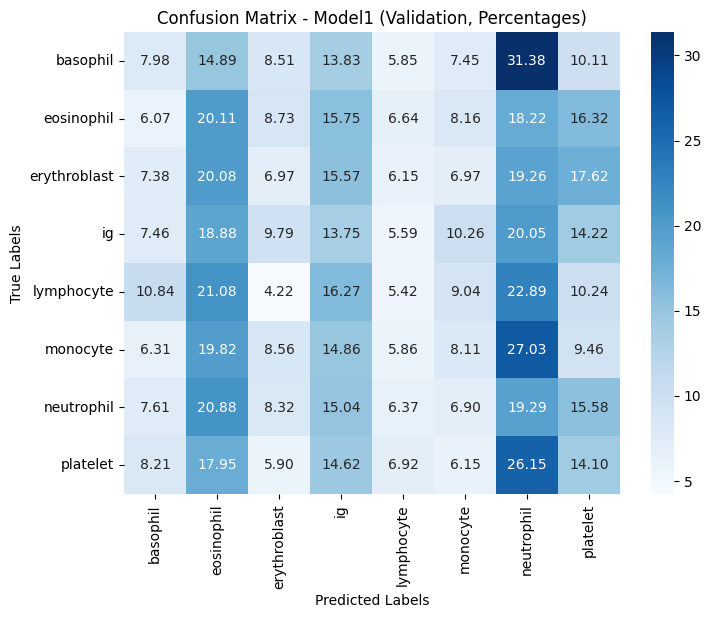

In [30]:
# Get the dataset
predictions_val_model1 = model1.predict(val_dataset)
predicted_labels_val_model1 = np.argmax(predictions_val_model1, axis=1)

# Get the labels
true_labels_val_model1 = np.concatenate([labels.numpy() for _, labels in val_dataset])

# Generate confusion matrix for the validation dataset
conf_matrix_val_model1 = confusion_matrix(true_labels_val_model1, predicted_labels_val_model1)

# Calculate percentages
conf_matrix_val_percentages_model1 = conf_matrix_val_model1 / conf_matrix_val_model1.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix using seaborn with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val_percentages_model1, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Model1 (Validation, Percentages)')
plt.show()

In [ ]:
# Verwenden Sie die predict-Methode, um Vorhersagen für den Testdatensatz zu generieren
predictions_test = model1.predict(test_dataset)

# Beispiel, wie Sie die Vorhersagen interpretieren könnten
predicted_labels_test = np.argmax(predictions_test, axis=1)

# Hier zeigen wir nur die ersten 10 Bilder an
for images, true_labels in test_dataset.take(1):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Predicted: {predicted_labels_test[i]}\nTrue: {true_labels[i].numpy()}")
        plt.axis("off")
    plt.show()

## Model 2 - CNN mit mehr Layer

In [31]:
# Build a more complex CNN
model2 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(128, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.8),
    layers.Dense(8, activation='softmax')
])

model2.summary()

# Compile the model
model2.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
history2 = model2.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[callBack])

result2 = model2.evaluate(test_dataset)

print("Test Loss:", result2[0])
print("Test Accuracy:", result2[1])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_113 (Conv2D)         (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_114 (Conv2D)         (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_115 (Conv2D)         (None, 52, 52, 64)       

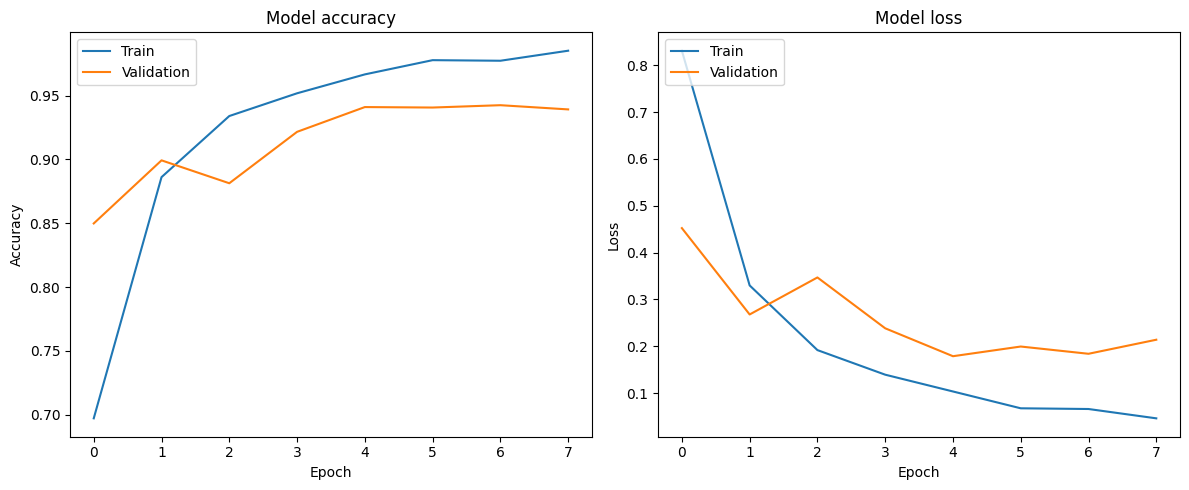

In [32]:
# Plot training & validation accuracy valuess
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

107/107 [==============================] - 9s 83ms/step


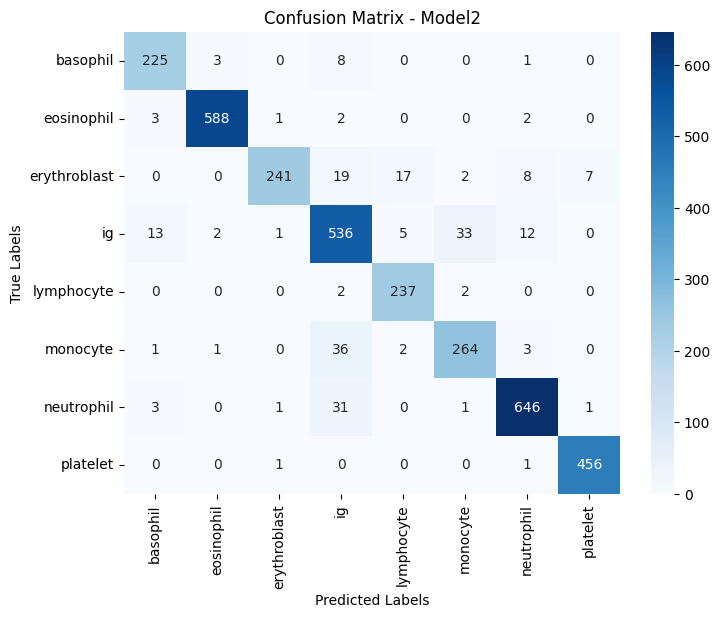

In [33]:
# Get the dataset
predictions_model2 = model2.predict(test_dataset)
predicted_labels_model2 = np.argmax(predictions_model2, axis=1)

# Get the labels
true_labels_model2 = np.concatenate([labels.numpy() for _, labels in test_dataset])

# Generate confusion matrix
conf_matrix_model2 = confusion_matrix(true_labels_model2, predicted_labels_model2)

# Calculate percentages
conf_matrix_percentages_model2 = conf_matrix_model2 / conf_matrix_model2.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentages_model2, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Model2')
plt.show()


86/86 [==============================] - 32s 85ms/step


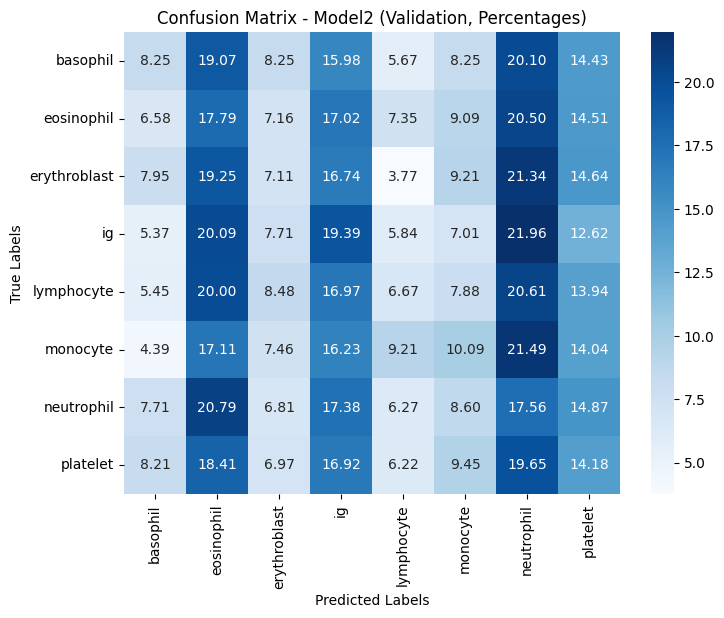

In [34]:
# Get the dataset
predictions_val_model2 = model2.predict(val_dataset)
predicted_labels_val_model2 = np.argmax(predictions_val_model2, axis=1)

# Get the labels
true_labels_val_model2 = np.concatenate([labels.numpy() for _, labels in val_dataset])

# Generate confusion matrix for the validation dataset
conf_matrix_val_model2 = confusion_matrix(true_labels_val_model2, predicted_labels_val_model2)

# Calculate percentages
conf_matrix_val_percentages_model2 = conf_matrix_val_model2 / conf_matrix_val_model2.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix using seaborn with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val_percentages_model2, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Model2 (Validation, Percentages)')
plt.show()

In [ ]:
# Verwenden Sie die predict-Methode, um Vorhersagen für den Testdatensatz zu generieren
predictions_test = model2.predict(test_dataset)

# Beispiel, wie Sie die Vorhersagen interpretieren könnten
predicted_labels_test = np.argmax(predictions_test, axis=1)

# Hier zeigen wir nur die ersten 10 Bilder an
for images, true_labels in test_dataset.take(1):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Predicted: {predicted_labels_test[i]}\nTrue: {true_labels[i].numpy()}")
        plt.axis("off")
    plt.show()

## Model 3 - CNN mit doppelten Layer

In [35]:
# New CNN
model3 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    # First Convolutional Block
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Second Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Third Convolutional Block with Exponential Increase
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(8, activation='softmax')
])

model3.summary()

model3.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

history3 = model3.fit(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[callBack])

result3 = model3.evaluate(test_dataset)

print("Test Loss: ", result3[0])
print("Test Accuracy:  ", result3[1])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_116 (Conv2D)         (None, 222, 222, 16)      448       
                                                                 
 conv2d_117 (Conv2D)         (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_118 (Conv2D)         (None, 108, 108, 32)      4640      
                                                                 
 conv2d_119 (Conv2D)         (None, 106, 106, 32)      9248      
                                                      

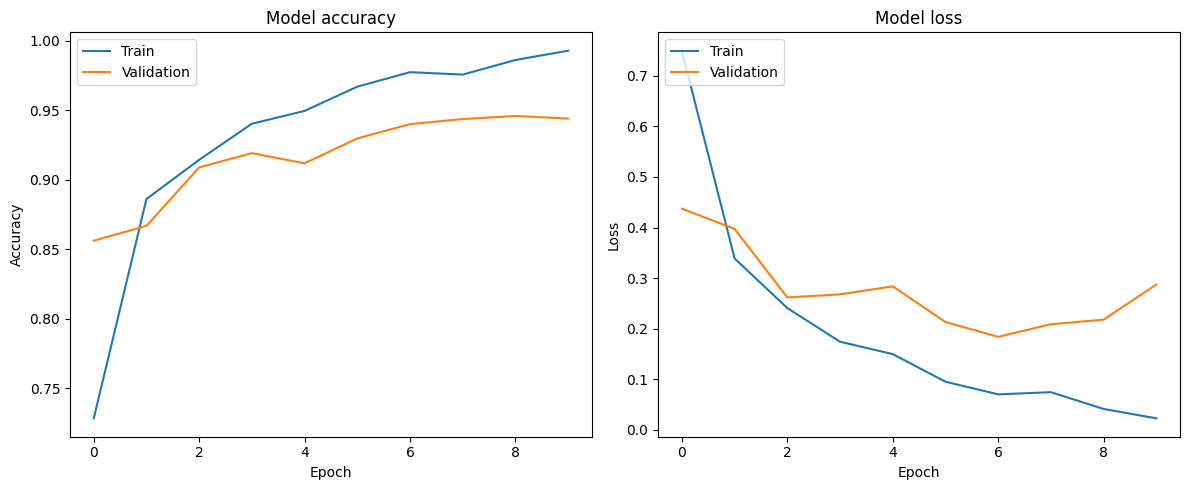

In [36]:
# Plot training & validation accuracy valuess
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

107/107 [==============================] - 10s 93ms/step


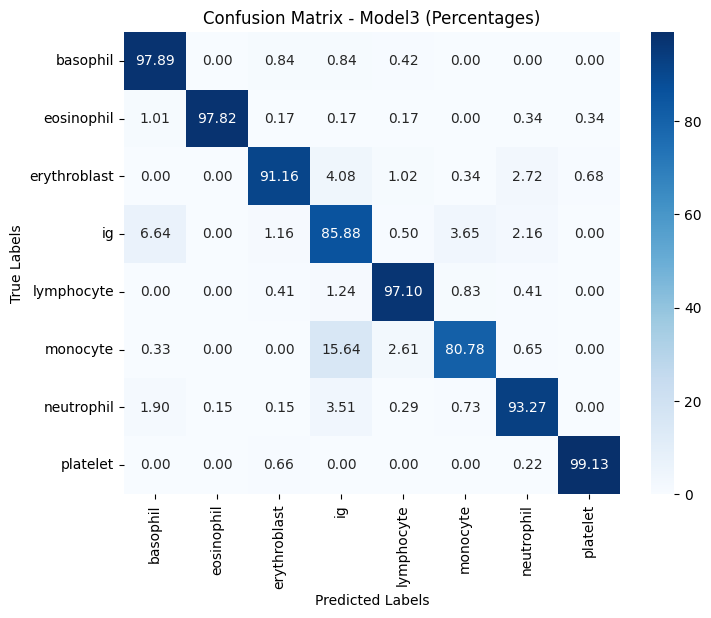

In [37]:
# Get the dataset
predictions_model3 = model3.predict(test_dataset)
predicted_labels_model3 = np.argmax(predictions_model3, axis=1)

# Get the labels
true_labels_model3 = np.concatenate([labels.numpy() for _, labels in test_dataset])

# Generate confusion matrix
conf_matrix_model3 = confusion_matrix(true_labels_model3, predicted_labels_model3)

# Calculate percentages
conf_matrix_percentages_model3 = conf_matrix_model3 / conf_matrix_model3.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix using seaborn with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentages_model3, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Model3 (Percentages)')
plt.show()


86/86 [==============================] - 30s 67ms/step


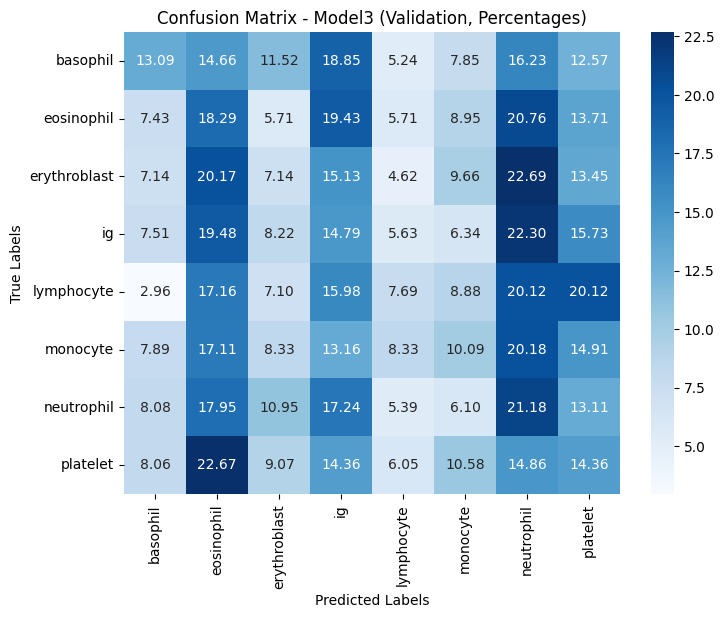

In [38]:
# Get the dataset
predictions_val_model3 = model3.predict(val_dataset)
predicted_labels_val_model3 = np.argmax(predictions_val_model3, axis=1)

# Get the labels
true_labels_val_model3 = np.concatenate([labels.numpy() for _, labels in val_dataset])

# Generate confusion matrix for the validation dataset
conf_matrix_val_model3 = confusion_matrix(true_labels_val_model3, predicted_labels_val_model3)

# Calculate percentages
conf_matrix_val_percentages_model3 = conf_matrix_val_model3 / conf_matrix_val_model3.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix using seaborn with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val_percentages_model3, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Model3 (Validation, Percentages)')
plt.show()


In [ ]:
# Verwenden Sie die predict-Methode, um Vorhersagen für den Testdatensatz zu generieren
predictions_test = model3.predict(test_dataset)

# Beispiel, wie Sie die Vorhersagen interpretieren könnten
predicted_labels_test = np.argmax(predictions_test, axis=1)

# Hier zeigen wir nur die ersten 10 Bilder an
for images, true_labels in test_dataset.take(1):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Predicted: {predicted_labels_test[i]}\nTrue: {true_labels[i].numpy()}")
        plt.axis("off")
    plt.show()

## Model 4 - CNN with layer order upside down

In [39]:
# New CNN
model4 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    # First Convolutional Block
    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Third Convolutional Block with Exponential Increase
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(8, activation='softmax')
])

model4.summary()

model4.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

history4 = model4.fit(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[callBack])

result4 = model4.evaluate(test_dataset)

print("Test Loss: ", result4[0])
print("Test Accuracy:  ", result4[1])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_122 (Conv2D)         (None, 220, 220, 128)     9728      
                                                                 
 conv2d_123 (Conv2D)         (None, 218, 218, 64)      73792     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 109, 109, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_124 (Conv2D)         (None, 107, 107, 64)      36928     
                                                                 
 conv2d_125 (Conv2D)         (None, 105, 105, 64)      36928     
                                                      

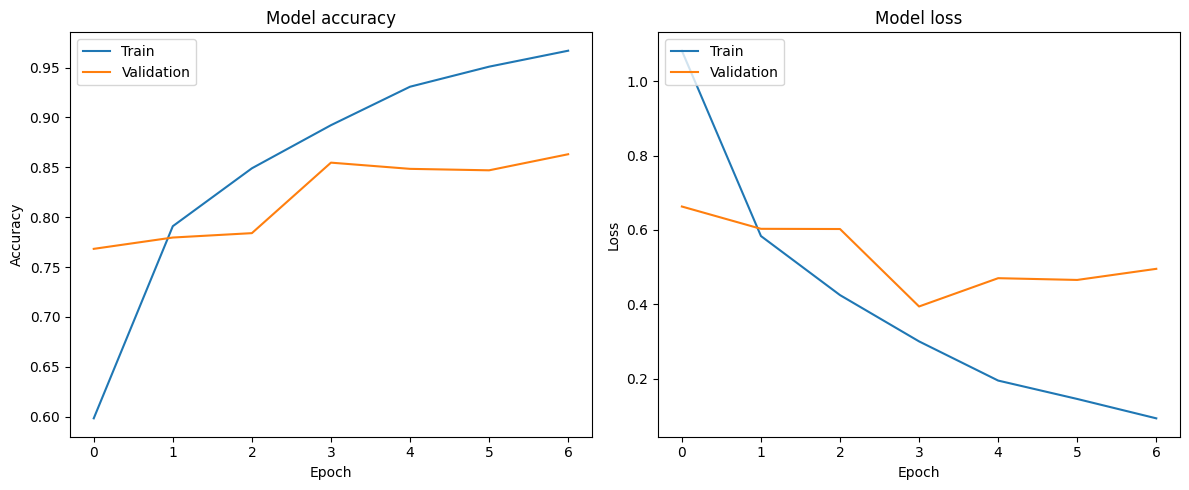

In [40]:
# Plot training & validation accuracy valuess
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

107/107 [==============================] - 9s 84ms/step


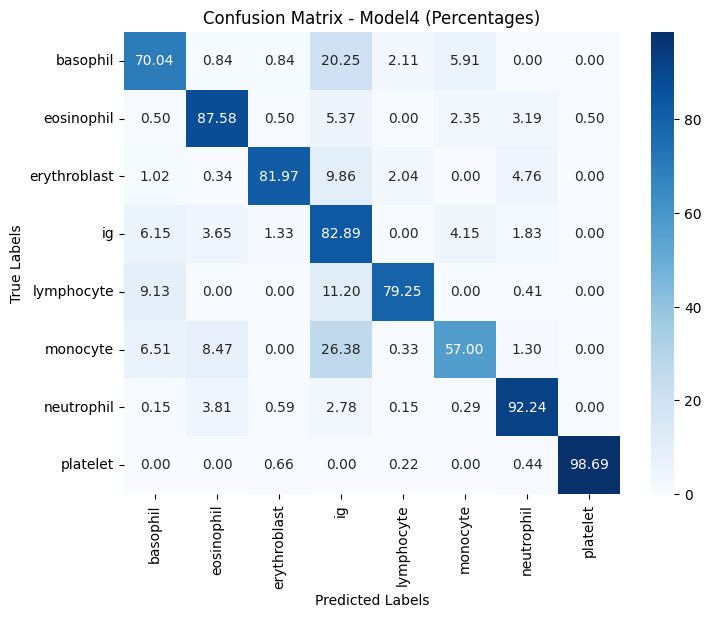

In [41]:
# Get the dataset
predictions_model4 = model4.predict(test_dataset)
predicted_labels_model4 = np.argmax(predictions_model4, axis=1)

# Get the labels
true_labels_model4 = np.concatenate([labels.numpy() for _, labels in test_dataset])

# Generate confusion matrix
conf_matrix_model4 = confusion_matrix(true_labels_model4, predicted_labels_model4)

# Calculate percentages
conf_matrix_percentages_model4 = conf_matrix_model4 / conf_matrix_model4.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix using seaborn with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentages_model4, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Model4 (Percentages)')
plt.show()


86/86 [==============================] - 31s 100ms/step


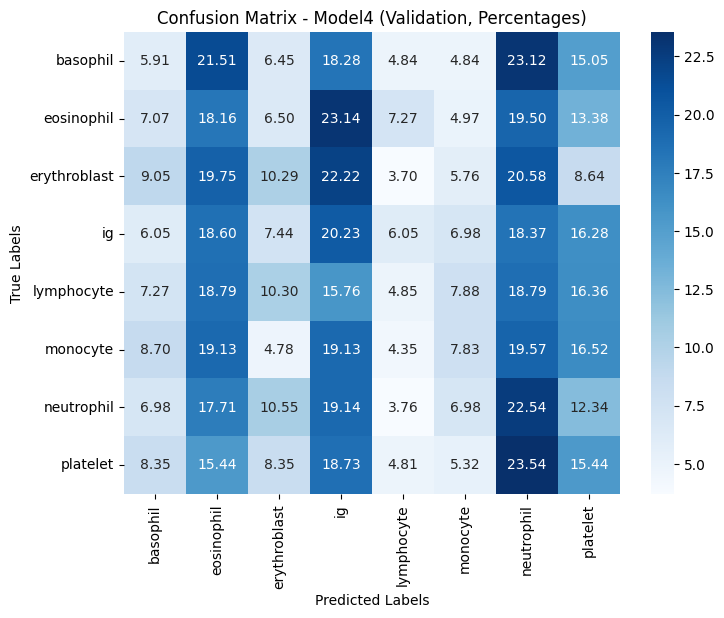

In [42]:
# Get the dataset
predictions_val_model4 = model4.predict(val_dataset)
predicted_labels_val_model4 = np.argmax(predictions_val_model4, axis=1)

# Get the labels
true_labels_val_model4 = np.concatenate([labels.numpy() for _, labels in val_dataset])

# Generate confusion matrix for the validation dataset
conf_matrix_val_model4 = confusion_matrix(true_labels_val_model4, predicted_labels_val_model4)

# Calculate percentages
conf_matrix_val_percentages_model4 = conf_matrix_val_model4 / conf_matrix_val_model4.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix using seaborn with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val_percentages_model4, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Model4 (Validation, Percentages)')
plt.show()


In [ ]:
# Verwenden Sie die predict-Methode, um Vorhersagen für den Testdatensatz zu generieren
predictions_test = model4.predict(test_dataset)

# Beispiel, wie Sie die Vorhersagen interpretieren könnten
predicted_labels_test = np.argmax(predictions_test, axis=1)

# Hier zeigen wir nur die ersten 10 Bilder an
for images, true_labels in test_dataset.take(1):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Predicted: {predicted_labels_test[i]}\nTrue: {true_labels[i].numpy()}")
        plt.axis("off")
    plt.show()

## ModelX - Bubeli spiele, bubeli gsund

In [25]:
from  keras.applications import InceptionV3

base_modelX = InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                     include_top=False,
                     weights='imagenet')

base_modelX.trainable = False

modelX = keras.Sequential([
    base_modelX,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

modelX.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

modelX.summary()

historyX = modelX.fit(train_dataset, validation_data=val_dataset, epochs=10)

resultX = modelX.evaluate(test_dataset)
print('Test Loss: ', resultX[0])
print('Test Accuracy: ', resultX[1])

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 22329384 (85.18 MB)
Trainable params: 526

KeyboardInterrupt: ignored

Das zweite Modell braucht zu viel Zeit und ist nicht in der Volesung enthalten. Fazit -> Keine verwendung